In [242]:

# coding: utf-8

# In[438]:

import re
import numpy as np
import os
import codecs

rootDir = '.'
TOTAL_TRAINING_DOCUMENT_COUNT = 0
DOCUMENT_COUNT_PER_AUTHOR = {}
VOCABULARY = set()
authorBags = {}
authorFeatures = {}

def tokenize(text, choice): #if choice is 1 return the bag of words, else return the unique words with their counts
    bag = re.split('\W+', text)
    counts = {}
    for x in set(bag):
        counts.update({x:bag.count(x)})
    if choice:
        return bag
    else:
        return counts

    
def mean_var(counts): #gets a list of feature counts(comma count, word count etc.) of multiple files of one author and returns the mean and the variance of that sample.
    mean = sum(counts)/len(counts)
    var = 0 #variance
    for i in range(0, len(counts)):
        var += (counts[i]-mean)**2
    var /= len(counts)
    return mean,var

def gaussian_pdf_value(mean,var,value):
    if var==0:
        return 1e-40
    pdf = (1/np.sqrt(2*np.pi*var)) * np.exp(-1*(((value-mean)**2)/(2*var)))
    
    if pdf == 0:
        return 1e-40
    
    return pdf 

def z_score(mean, var, value):
    if var==0:
        return np.log(1e-40)
    return abs(value-mean)/np.sqrt(var)

for dirName, subdirList, fileList in os.walk(rootDir+'/trainingSet'):
    if(dirName != './trainingSet'):
        currDir = dirName[14:]
        
        authorBags.update({currDir:{}})
        authorFeatures.update({currDir:{'wordCount':[], #wordCount: total word count for the author.
                                        'sentenceCount':[], #sentenceCount: sentence count per document for the author.
                                        'wordLength':[], #wordLength: average word length for the author.
                                        'commaCount':[], #commaCount: average number of commas per sentence for the author.
                                        'exclamationCount':[], #exclamationCount: average number of exclamation marks per sentence for the author.
                                        'questionCount':[] #questionCount: average number of question marks per sentence for the author.
                                       }}) 



        #print(authorBags)
        fileCount = len(fileList)
        ##print(dirName)
        DOCUMENT_COUNT_PER_AUTHOR.update({currDir:0})
        
        for fname in fileList:
            TOTAL_TRAINING_DOCUMENT_COUNT += 1
            DOCUMENT_COUNT_PER_AUTHOR[currDir] += 1
            text = ''
            with codecs.open(dirName+'/'+fname, 'r', 'ISO-8859-9') as myfile:
                ##print(dirName+'/'+fname)
                text = myfile.read().lower()

                bagCounts = tokenize(text,0)
                wordCount = 0
                wordLength = 0
                
                for word in bagCounts:
                    wordCount += bagCounts[word]
                    wordLength += bagCounts[word]*len(word)                    
                    
                    newWord = ''
                    if word.isdigit(): newWord = 'NUMBER'
                    else: newWord = word
                    
                    if newWord in authorBags[currDir]:
                        authorBags[currDir][newWord] += bagCounts[word]
                    else:
                        authorBags[currDir].update({newWord:bagCounts[word]})
                
                sentcount = text.count('.') #sentence count
                authorFeatures[currDir]['wordCount'].append(wordCount) #word count of the current file
                authorFeatures[currDir]['wordLength'].append(wordLength/wordCount) #average word length for the current file
                authorFeatures[currDir]['sentenceCount'].append(sentcount)
                authorFeatures[currDir]['commaCount'].append(text.count(',')/sentcount)
                authorFeatures[currDir]['exclamationCount'].append(text.count('!')/sentcount)
                authorFeatures[currDir]['questionCount'].append(text.count('?')/sentcount)
                
        if '' in authorBags[currDir]: del authorBags[currDir]['']
            
        VOCABULARY.update(authorBags[currDir].keys())
        
        for key in authorFeatures[currDir].keys():
            authorFeatures[currDir][key] = mean_var(authorFeatures[currDir][key])





In [255]:
# In[439]:

def text_class(text): 
    maxProb = -float('Inf')
    maxAuth = ''
    vocabSize = len(VOCABULARY)

    sentenceCount = text.count('.')
    commaCount = text.count(',')
    exclamationCount = text.count('!')
    questionCount = text.count('?')
    
    tokens = tokenize(text,1)
    prob = 0
    for authName in authorBags:
        n = sum(authorBags[authName].values())
        #print(n , authName)
        prob = 0
        wordLength = 0
        
        for token in tokens:
            wordLength += len(token)
            smoother = 0.004
            if token in authorBags[authName]:
                tokenProb = (authorBags[authName][token]+smoother)/(n+smoother*vocabSize)
            else:
                tokenProb = smoother/(n+smoother*vocabSize)
            prob = prob + np.log(tokenProb)
            #print('tokenProb = ' , tokenProb)
        
        wordLength /= len(tokens)
        
        authorProb = DOCUMENT_COUNT_PER_AUTHOR[authName] / TOTAL_TRAINING_DOCUMENT_COUNT
        #print('authorProb = ', np.log(authorProb))
        prob += np.log(authorProb)
        
        prob -= 2*z_score(authorFeatures[authName]['wordCount'][0], 
                          authorFeatures[authName]['wordCount'][1], 
                          len(tokens))
        
        prob -= 2*z_score(authorFeatures[authName]['sentenceCount'][0], 
                           authorFeatures[authName]['sentenceCount'][1], 
                           sentenceCount)
        
        prob -= 2*z_score(authorFeatures[authName]['wordLength'][0], 
                           authorFeatures[authName]['wordLength'][1], 
                           wordLength)
        
        prob -= 2*z_score(authorFeatures[authName]['commaCount'][0], 
                           authorFeatures[authName]['commaCount'][1], 
                           commaCount/sentenceCount)
        
        prob -= 2*z_score(authorFeatures[authName]['exclamationCount'][0], 
                           authorFeatures[authName]['exclamationCount'][1], 
                           exclamationCount/sentenceCount)
        
        prob -= 2*z_score(authorFeatures[authName]['questionCount'][0], 
                           authorFeatures[authName]['questionCount'][1], 
                           questionCount/sentenceCount)
        
        """prob += np.log(gaussian_pdf_value(authorFeatures[authName]['wordCount'][0], 
                          authorFeatures[authName]['wordCount'][1], 
                          len(tokens)))
        
        prob += np.log(gaussian_pdf_value(authorFeatures[authName]['sentenceCount'][0], 
                           authorFeatures[authName]['sentenceCount'][1], 
                           sentenceCount))
        
        prob += np.log(gaussian_pdf_value(authorFeatures[authName]['wordLength'][0], 
                           authorFeatures[authName]['wordLength'][1], 
                           wordLength))
        
        prob += np.log(gaussian_pdf_value(authorFeatures[authName]['commaCount'][0], 
                           authorFeatures[authName]['commaCount'][1], 
                           commaCount/sentenceCount))

        
        prob += np.log(gaussian_pdf_value(authorFeatures[authName]['exclamationCount'][0], 
                           authorFeatures[authName]['exclamationCount'][1], 
                           exclamationCount/sentenceCount))
        
        prob += np.log(gaussian_pdf_value(authorFeatures[authName]['questionCount'][0], 
                           authorFeatures[authName]['questionCount'][1], 
                           questionCount/sentenceCount))"""
        
        
        """     prob -= abs(authorFeatures[authName]['wordCount'] - len(tokens))
                prob -= abs(authorFeatures[authName]['sentenceCount'] - sentenceCount)
                prob -= 10*abs(authorFeatures[authName]['wordLength'] - wordLength)
                prob -= 100*abs(authorFeatures[authName]['commaCount'] - commaCount/sentenceCount)
                prob -= 1000*abs(authorFeatures[authName]['exclamationCount'] - exclamationCount/sentenceCount)
                prob -= 1000*abs(authorFeatures[authName]['questionCount'] - questionCount/sentenceCount)
        """
        #print(wordLength)
        #print(abs(authorFeatures[authName]['wordLength'] - wordLength))
        if prob > maxProb:
            maxProb = prob
            maxAuth = authName
        #print('Prob for auth ',authName, prob)
    
    #print(maxAuth)
    return maxAuth

In [ ]:

# In[440]:

"""with codecs.open('./testSet/ahmetAltan/M7.txt', 'r', 'ISO-8859-9') as myfile:
    text = myfile.read()
    bagCounts = tokenize(text,1)
    text_class(bagCounts)"""

success = 0
totalTrial = 0
for dirName, subdirList, fileList in os.walk(rootDir+'/testSet'):
    if(dirName != './testSet'):
        currDir = dirName[10:]
        for fname in fileList:
            text = ''
            with codecs.open(dirName+'/'+fname, 'r', 'ISO-8859-9') as myfile:
                #print(dirName+'/'+fname)
                text = myfile.read().lower()
                auth = text_class(text)
                totalTrial += 1
                if auth == dirName[10:]:
                    #print('success')
                    success +=1
                #else:
                    #print('fail')
print('Finished')
print('Success rate :', success/ totalTrial)

In [105]:
# In[441]:



Success rate : 0.6703296703296703


In [173]:
# In[442]:
#0.7527472527472527
with codecs.open('./testSet/hasmetBabaoglu/8.txt', 'r', 'ISO-8859-9') as myfile:
    text = myfile.read()
    bagCounts = tokenize(text,1)
    print(text_class(text))

hasmetBabaoglu


In [245]:
z_score(772.6666666666666, 130.44444444444446, 146)

54.868590109271217

In [125]:
np.log(0)

/Users/macapple/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


-inf

0.439805283582
1.61121834387


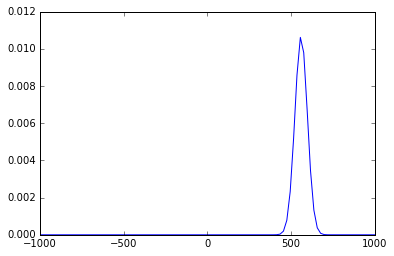

In [252]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

a=0.1
print(np.log(z_score(authorFeatures['abbasGuclu']['exclamationCount'][0], 
                           authorFeatures['abbasGuclu']['exclamationCount'][1], 
                           a)))


print(z_score(authorFeatures['abbasGuclu']['wordCount'][0], 
                           authorFeatures['abbasGuclu']['wordCount'][1], 
                           500))

mean = authorFeatures['abbasGuclu']['wordCount'][0]
variance = authorFeatures['abbasGuclu']['wordCount'][1]
sigma = math.sqrt(variance)
x = np.linspace(-1000,1000,100)
plt.plot(x,mlab.normpdf(x,mean,sigma))

plt.show()

NameError: name 'var' is not defined

1.9410835087212867e-12

0.0014627058398094506